In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import asyncio
from itertools import cycle, islice
import json
from lib import models
from lib.grpo import GRPO
from lib.inference_early_stop import InferenceEarlyStop
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.temporal_clue import get_temporal_clue_tasks
from lib.tokenize import TaskResultTokenizer, TokenizedResult
from lib.tune import (
    clear_iteration_dirs,
    get_iteration,
    get_last_iteration_dir,
    last_tune_log,
    tune,
    Verbosity,
)
from lib.utils import symlink_shm, rsync_dir
from lib.vllm import start_vllm, kill_vllm_workers
import polars as pl
import random
import torch
from transformers import AutoTokenizer
import wandb

run_name = "051"
run = wandb.init(
    project="rl-experiments",
    name=run_name,
    id=run_name,
    resume="allow",
    config={"task": "temporal-clue"},
)

tasks = list(get_temporal_clue_tasks())
val_tasks = tasks[:64]
test_tasks = tasks[64:128]
train_tasks = tasks[128:]
random.seed(42)
random.shuffle(train_tasks)
len(val_tasks), len(test_tasks), len(train_tasks)

wandb: Currently logged in as: bradhilton to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


(64, 64, 2860)

In [4]:
# GRPO params
wandb.config["clip_epsilon"] = clip_epsilon = 0.2
wandb.config["entropy_coef"] = entropy_coef = 0.0
wandb.config["kl_coef"] = kl_coef = 0.0
wandb.config["tanh"] = tanh = False

expected_tokens = 300  # Expected completion tokens per task sample
inference_early_stop = InferenceEarlyStop(alpha=0.992, threshold=-3.3)
wandb.config["lr"] = lr = 1e-5
wandb.config["betas"] = betas = (0.9, 0.99)
wandb.config["weight_decay"] = weight_decay = 0.1
model = models.theta_8b()
wandb.config["model"] = model.base_model
num_iterations = 1_000
output_dir = f"./models/{run_name}"
wandb.config["samples_per_task"] = samples_per_task = 50
wandb.config["seq_len"] = seq_len = 16384
wandb.config["stride"] = stride = 32
wandb.config["tasks_per_iter"] = tasks_per_iter = 64
sync_dir = output_dir  # symlink_shm(output_dir) or output_dir
tokenizer = AutoTokenizer.from_pretrained(model.base_model)
verbosity: Verbosity = 2
prev_deferred_results: list[list[TokenizedResult]] | None = None

tokenizer_config.json:   0%|          | 0.00/56.3k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

In [29]:
optimizer_config = ComponentConfig(
    model.tune_optimizer,
    lr=lr,
    betas=betas,
    weight_decay=weight_decay,
)
if model.tune_optimizer == "torch.optim.AdamW":
    optimizer_config.fused = True
model_name = await tune(
    base_model=model.base_model,
    output_dir=output_dir,
    packed_tensors=packed_tensors,
    model=model.tune_model,
    model_type=model.tune_model_type,
    config=TuneRecipeConfig(
        optimizer=optimizer_config,
        gradient_accumulation_steps=packed_tensors["tokens"].shape[0] // 2 - 2,
        max_steps_per_epoch=1,
        loss=ComponentConfig(
            GRPO,
            clip_epsilon=clip_epsilon,
            entropy_coef=entropy_coef,
            kl_coef=kl_coef,
            tanh=tanh,
        ),
        shuffle=False,
        batch_size=model.tune_max_batch_tokens // seq_len,
        fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
        enable_activation_checkpointing=True,
        enable_activation_offloading=True,
        custom_sharded_layers=["tok_embeddings", "output"],
        num_output_chunks=model.tune_num_output_chunks,
        compile=True,
        log_grad_magnitude=True,
    ),
    verbosity=verbosity,
)

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/051/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/051/0001
  checkpoint_files:
  - ft-model-00002-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00004-of-00004.safetensors
  - ft-model-00001-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./models/051
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/051/tensors
  num_sequences: 39
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 17
log_grad_magnitude: true
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef

Writing logs to models/051/logs/log_1740584830.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.90 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|1|Loss: 0.1354: 100%|██████████| 1/1 [07:03<00:00, 423.91s/it, loss=0.135, policy=0.135, entropy=0.457, kl_div=nan, grad_magnitude=40]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model sta

$ vllm serve /home/gcpuser/sky_workdir/experiments/models/051/0004 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/051/0004 --port=8003 --api-key=default
INFO 02-26 16:08:22 __init__.py:190] Automatically detected platform cuda.
INFO 02-26 16:08:22 api_server.py:840] vLLM API server version 0.7.2
INFO 02-26 16:08:22 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/051/0004', config='', host=None, port=8003, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_ro

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.29it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.24it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  1.81it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.54it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.51it/s]



INFO 02-26 16:08:37 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-26 16:08:38 worker.py:267] Memory profiling takes 0.99 seconds
INFO 02-26 16:08:38 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-26 16:08:38 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-26 16:08:39 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-26 16:08:39 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-26 16:09:26 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 48.43 seconds
INFO 02-26 16:09:27 api_server.py:756] Using supplied chat template:
INFO 02-26 16:09:27 api_server.py:756] None
INFO 02-26 16:09:27 launcher.py:21] Available routes are:
INFO 02-26 16:09:27 launcher.py:29] Route: /

INFO:     Started server process [61677]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8003 (Press CTRL+C to quit)


INFO 02-26 16:09:32 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-26 16:09:32 metrics.py:455] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-26 16:09:32 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:32770 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [01:39<00:00, 465.17it/s, completion_tokens=34, prompt_tokens=1145, reward=0.335, acc=0.335, token_logprobs=107842]
Deleted iteration directory ./models/051/0003


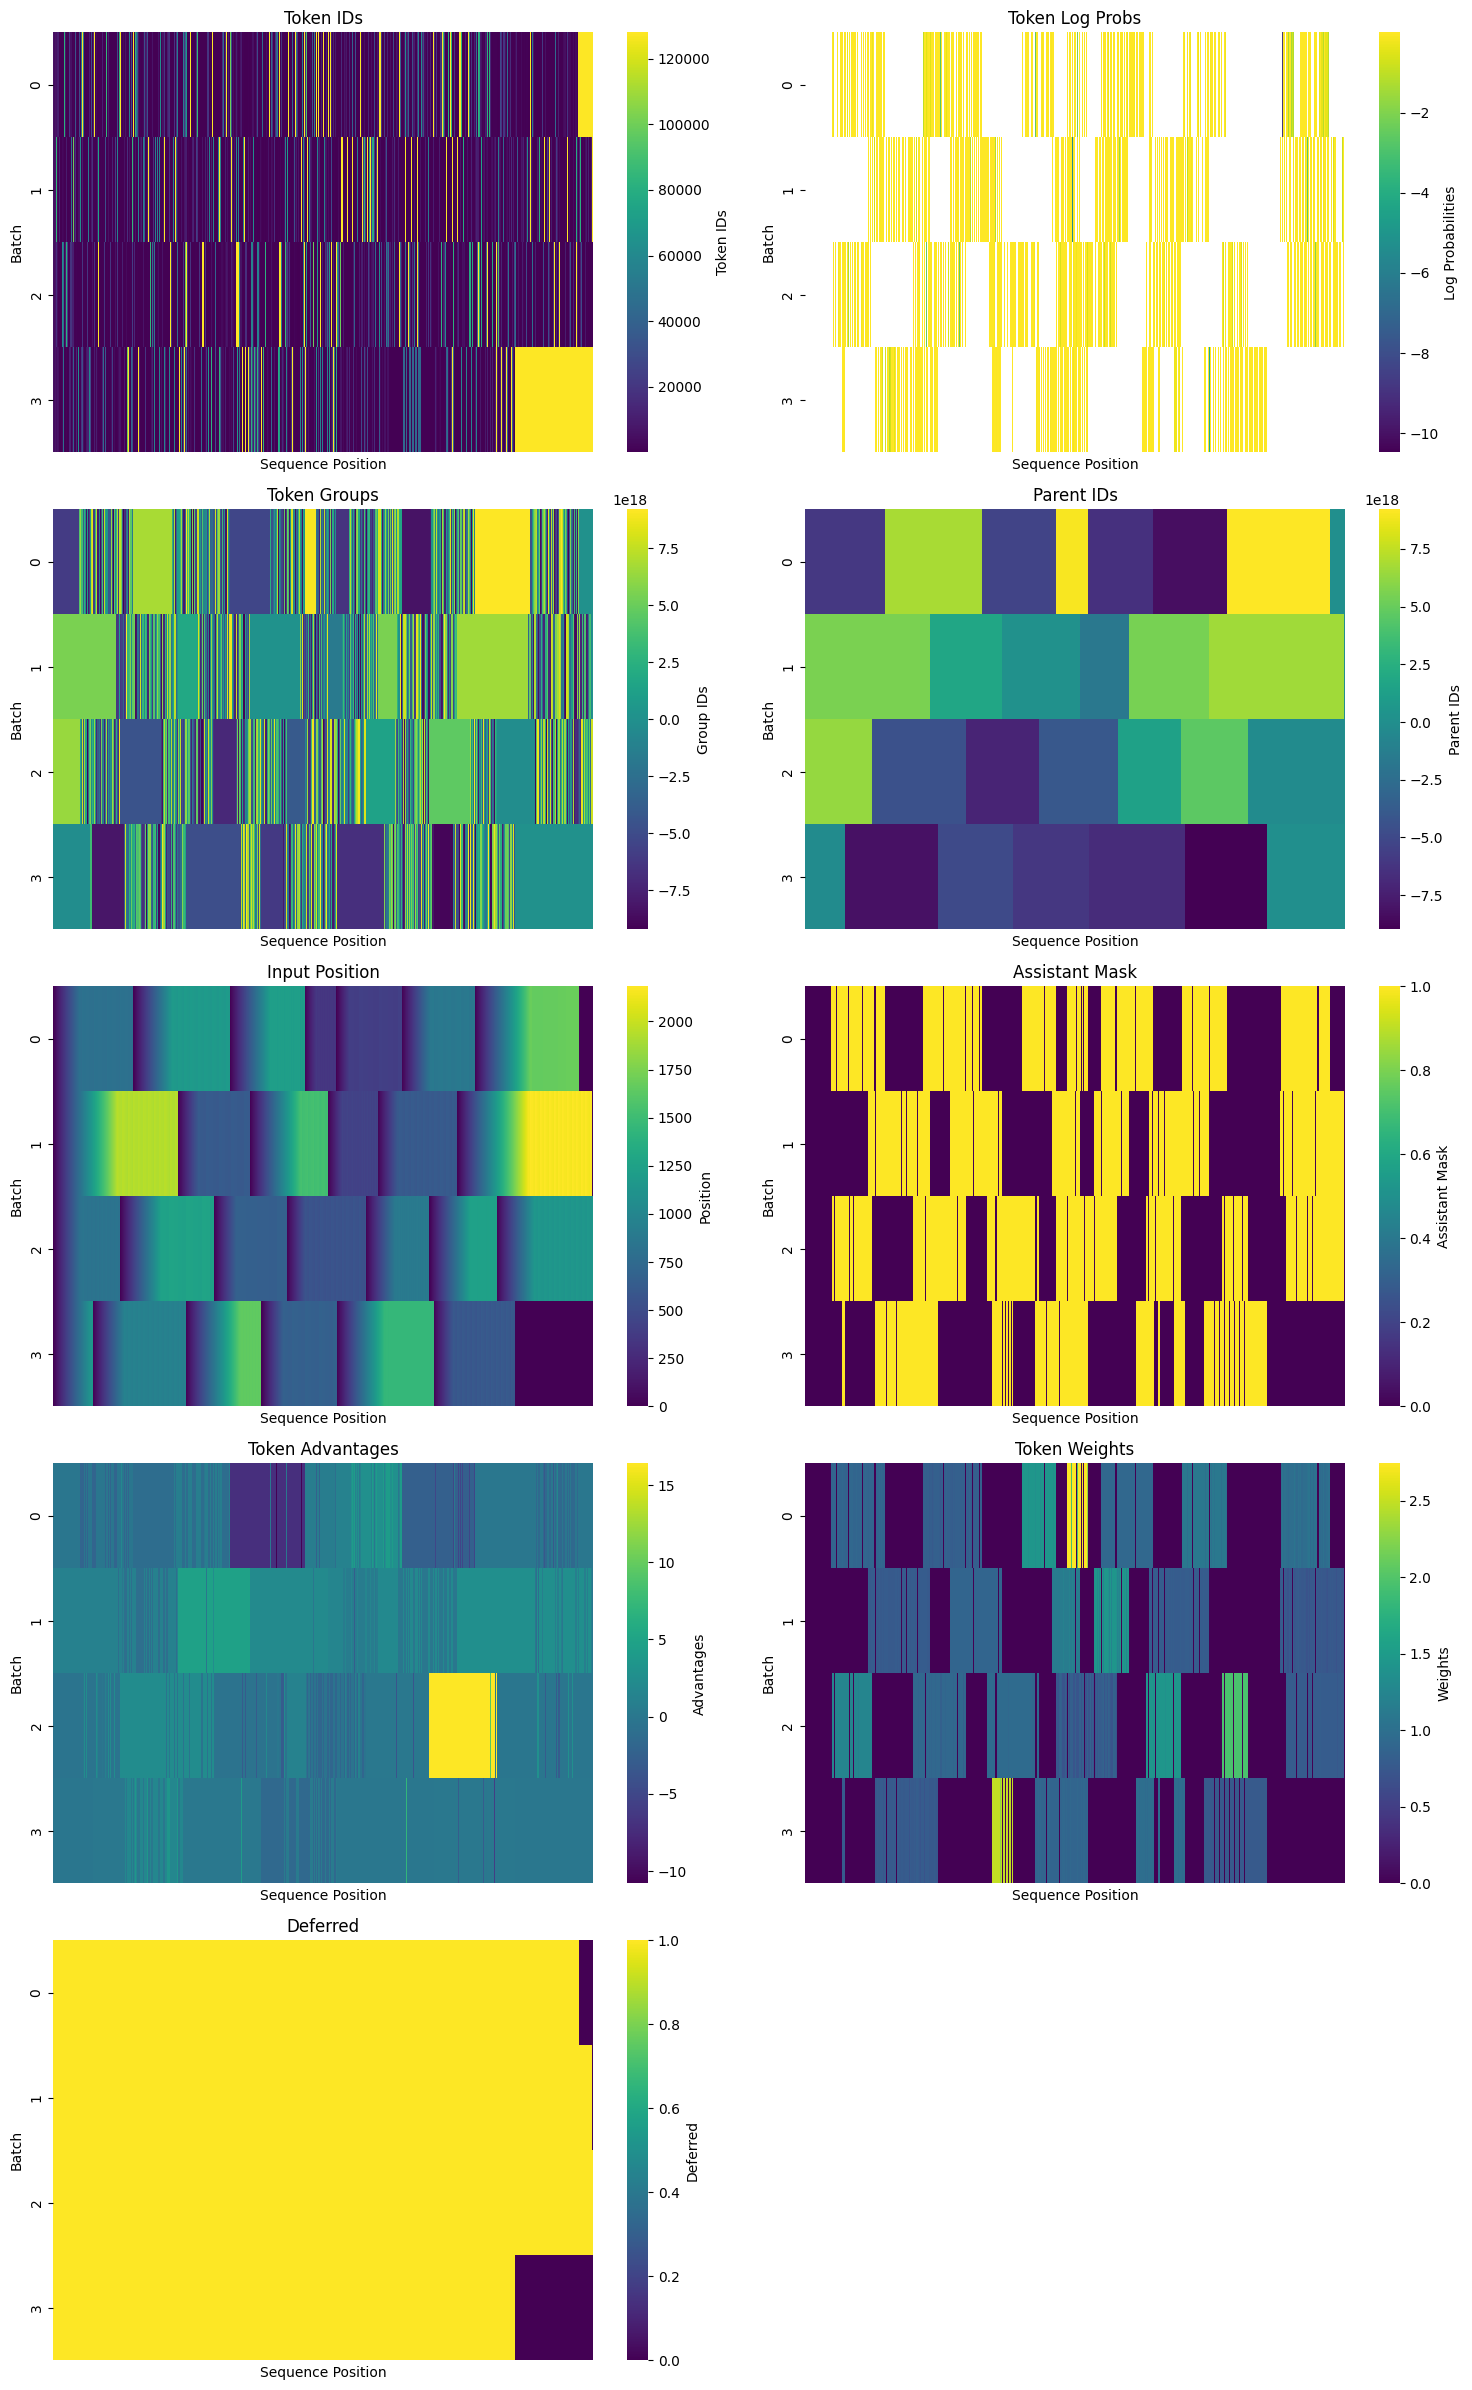

rsyncing /home/gcpuser/sky_workdir/experiments/models/051 to gs:/atreides/openpipe/models/051
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/051/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/051/0004
  checkpoint_files:
  - ft-model-00002-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00004-of-00004.safetensors
  - ft-model-00001-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./models/051
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/051/tensors
  num_sequences: 4
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
log_grad_magnitude: true
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 

Writing logs to models/051/logs/log_1740586295.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 18.83 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|1|Loss: -0.1592: 100%|██████████| 1/1 [00:29<00:00, 29.63s/it, loss=-0.159, policy=-0.159, entropy=0.0975, kl_div=nan, grad_magnitude=374]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model

rsyncing /home/gcpuser/sky_workdir/experiments/models/051 to gs:/atreides/openpipe/models/051
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/051/0005 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/051/0005 --port=8003 --api-key=default
INFO 02-26 16:13:04 __init__.py:190] Automatically detected platform cuda.
INFO 02-26 16:13:05 api_server.py:840] vLLM API server version 0.7.2
INFO 02-26 16:13:05 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/051/0005', config='', host=None, port=8003, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=No

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.39it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.32it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  1.91it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.58it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.57it/s]



INFO 02-26 16:13:19 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-26 16:13:20 worker.py:267] Memory profiling takes 0.94 seconds
INFO 02-26 16:13:20 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-26 16:13:20 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-26 16:13:20 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-26 16:13:20 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-26 16:14:07 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 47.97 seconds
INFO 02-26 16:14:08 api_server.py:756] Using supplied chat template:
INFO 02-26 16:14:08 api_server.py:756] None
INFO 02-26 16:14:08 launcher.py:21] Available routes are:
INFO 02-26 16:14:08 launcher.py:29] Route: /

INFO:     Started server process [65848]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8003 (Press CTRL+C to quit)


INFO 02-26 16:14:08 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:60284 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

val: 100%|██████████| 128/128 [00:40<00:00,  5.52it/s, completion_tokens=35, prompt_tokens=1124, reward=0.281, acc=0.281, token_logprobs=4516]


In [ ]:
model_name = get_last_iteration_dir(output_dir) or model.base_model
for i in range(get_iteration(output_dir), num_iterations):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=1024,
        env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=1024,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=240 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(
        int(1.33 * vllm.max_concurrent_tokens / expected_tokens)
    )
    offset = i * stride
    val_results, train_results = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            n=2,
            on_chunk=inference_early_stop,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            on_chunk=inference_early_stop,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    vllm.process.terminate()
    kill_vllm_workers()
    val_stats = val_results.stats
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_results.stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": round(val_stats.completion_tokens / val_stats.usages),
    }
    for metric in val_stats.total_metrics:
        wandb_data[metric] = val_stats.total_metrics[metric] / val_stats.grades
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = wandb_data["tokens"]
    try:
        best_iteration = (
            wandb.Api()
            .run(f"{run.entity}/{run.project}/{run.id}")
            .history()
            .sort_values(by="reward")["iteration"]
            .iloc[-1]
        )
        clear_iteration_dirs(output_dir, [best_iteration, i])
        # see ./logs/rsync.log for output
        asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/", output_dir))
    except Exception:
        pass
    # Deferred results
    train_results, deferred_results = (
        train_results[: len(train_results) // 2],
        train_results[len(train_results) // 2 :],
    )
    if prev_deferred_results is not None:
        for _deferred_results, _train_results in zip(
            prev_deferred_results, train_results
        ):
            mean_reward = (
                torch.tensor([result.reward for result in _train_results]).mean().item()
            )
            differences = [mean_reward - result.reward for result in _deferred_results]
            std_dev = torch.std(torch.tensor(differences)).item()
            for result, difference in zip(_deferred_results, differences):
                result.advantage = difference / std_dev if std_dev > 1e-2 else 0.0
                result.deferred = True
        random.shuffle(prev_deferred_results)
        random.shuffle(train_results)
        train_results = prev_deferred_results  # + train_results
    else:
        random.shuffle(train_results)
    prev_deferred_results = deferred_results
    tokenized_results = [
        result
        for results in train_results
        for result in results
        if result.advantage != 0
    ]
    packed_tensors = packed_tensors_from_tokenized_results(
        tokenized_results,
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(
        model.tune_optimizer,
        lr=lr,
        betas=betas,
        weight_decay=weight_decay,
    )
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    batch_size = model.tune_max_batch_tokens // seq_len
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir,
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            optimizer=optimizer_config,
            gradient_accumulation_steps=max(
                packed_tensors["tokens"].shape[0] // batch_size - batch_size, 1
            ),
            max_steps_per_epoch=1,
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
                tanh=tanh,
            ),
            shuffle=False,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=model.tune_num_output_chunks,
            compile=True,
            log_grad_magnitude=True,
        ),
        verbosity=verbosity,
    )
    # see ./logs/rsync.log for output
    asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/", output_dir))